In [1]:
import re
from unicodedata import normalize
from string import punctuation
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import spacy
import nltk
from nltk.cluster import KMeansClusterer
from nltk.corpus import stopwords
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import homogeneity_score, completeness_score, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding
from sklearn.decomposition import NMF
from sklearn.cluster import DBSCAN, OPTICS, KMeans
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

warnings.filterwarnings('ignore')
np.random.seed(123456)

%matplotlib inline

In [2]:
def remover_acentos(txt):
    return normalize('NFKD', txt).encode('ASCII', 'ignore').decode('ASCII')

def is_number(s):
    try:
        complex(s) # for int, long, float and complex
    except ValueError:
        return False
    return True

def tokenizer(phrase):
    phrase = phrase.lower()
    for o, r in RM:
        phrase = re.sub(o, r, phrase, flags=re.MULTILINE)
    phrase = NLP(re.sub(r'["\'@#%\(\)]', "", phrase), disable=["parser"])
    clean_frase = []
    for palavra in phrase:
        if palavra.pos_ != "PUNCT":
            word = palavra.text.strip()
            if not is_number(word) and word not in STOPWORDS and len(word) > 1:
                # clean_frase += [STEMMER.stem(remover_acentos(palavra.lemma_))]
                clean_frase += [remover_acentos(palavra.text)]
    return clean_frase

def _get_stopwords():
    stpwords = stopwords.words('portuguese') + list(punctuation)
    rms = ['um', 'não', 'mais', 'muito']
    for rm in rms:
        del stpwords[stpwords.index(rm)]
    return stpwords

NLP = spacy.load("pt")
# STEMMER = nltk.stem.RSLPStemmer()
STEMMER = nltk.stem.SnowballStemmer('portuguese')
STOPWORDS = _get_stopwords()
RM = [
    ('\n', '. '), ('"', ''), ('@', ''),
    ('#', ''), ('RT', ''), (r'(http[s]*?:\/\/)+.*[\r\n]*', '')
]

colors = np.asarray([
    (230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200), (245, 130, 48), (145, 30, 180), (70, 240, 240),
    (240, 50, 230), (210, 245, 60), (250, 190, 190), (0, 128, 128), (230, 190, 255), (170, 110, 40), (255, 250, 200),
    (128, 0, 0), (170, 255, 195), (128, 128, 0), (255, 215, 180), (0, 0, 128), (128, 128, 128), (0, 0, 0),
    (141, 204, 226), (212, 50, 147), (251, 226, 93), (16, 185, 176), (189, 182, 163), (244, 172, 18), (100, 28, 112),
    (165, 124, 92), (183, 160, 211), (66, 47, 105), (240, 67, 7), (244, 188, 198)
]).astype(np.float32)

colors /= 255.0

### Carregamento dos datasets

Os datasets de exemplos são frases já pré-categorizadas usadas em chatbots.

Contém 33 categorias e ao todo 696 documentos ou frases.

In [3]:
df_data1 = pd.read_csv("intents.csv", sep=';', names=["cluster", "perguntas"])
df_data2 = pd.read_csv("ground_truth.csv", sep=';', names=["perguntas", "cluster"])

df_data1 = df_data1[df_data1.columns[::-1]]
df_data = pd.concat([df_data1, df_data2], sort=False)
df_data.dropna(inplace=True)
df_data['cluster'] = df_data['cluster'].str.upper()

T = df_data.to_numpy()
index = np.random.choice(T.shape[0], 10, replace=False)
display(df_data.iloc[index].sort_values(by=["cluster"]))

c = np.argmax(pd.get_dummies(df_data["cluster"]).to_numpy(), axis=1)

N = df_data["cluster"].to_numpy().shape[0]
clusters = len(set(c))

,perguntas,cluster
250,como solicitar um novo certificado digital para um sistema que criei no me departamento?,CERTIFICADO
212,esta dando erro ao tentar criar meu novo username,CONTA
234,"estou tentanto criar meu username, mas não estou conseguindo",CONTA
77,obrigado mesmo,OBRIGADO
13,Como posso registrar um cartão SIM?,TELCO_ACTIVATE_DEVICE
70,"Fui assaltado, preciso acionar seguro.",TELCO_ADD_INSURANCE
179,Por favor me diga quando eu vou ser elegível para minha próxima atualização do dispositivo.,TELCO_DEVICE_UPGRADE_ELIGIBILITY
223,"Eu não sei porque, mas o meu telefone não funciona em casa.",TELCO_NETWORK_COMPLAINTS
253,Eu tenho um cartão SIM no meu aparelho e eu gostaria de desbloqueá-lo.,TELCO_NETWORK_UNLOCK
261,Posso levar meu telefone comigo se eu mudar para uma nova empresa.,TELCO_PORT_IN


In [4]:
uniq, cnt = np.unique(np.asarray(df_data["cluster"]), return_counts=True)
df_org = pd.DataFrame(np.array(list(zip(uniq, cnt))), columns=["Categoria", "Qtde"])

print("Qtde. de documentos por categoria:")
display(df_org.sort_values(by=["Categoria"]))

Qtde. de documentos por categoria:


,Categoria,Qtde
0,ACESSO_REMOTO,20
1,CERTIFICADO,18
2,CONTA,29
3,DUVIDAS,17
4,EMAIL,40
5,LINGUAJAR,24
6,NENHUMA_OPCAO,20
7,NOME_BOT,16
8,OBRIGADO,23
9,SENHAS,27


In [5]:
X_train, X_test, y_train, y_test = train_test_split(df_data["perguntas"], c, test_size=0.2)

qtde_docs = len(df_data["perguntas"])
qtde_categ = len(df_data["cluster"])
print(f"Total docs     : {qtde_docs}")
print(f"Total cluster  : {qtde_categ}")
print(f"X_train size   : {X_train.shape}")
print(f"X_test  size   : {X_test.shape}")

Total docs     : 696
Total cluster  : 696
X_train size   : (556,)
X_test  size   : (140,)


### Dataset tokenization

In [6]:
P = X_train.shape[0]
print("Tokenization...")
documents_tfidf = [" ".join(tokenizer(doc)) for doc in X_train]
print("Qtd documentos treino: ", len(documents_tfidf))
print("Qtd Intents treino   : ", len(np.unique(df_data["cluster"].to_numpy())))
print("Finished...")

Tokenization...
Qtd documentos treino:  556
Qtd Intents treino   :  33
Finished...


In [7]:
documents_tfidf[:10]

['quero mudar servico um novo dispositivo mantendo mesmos dados pessoais pode dizer faze-lo',
 'quais outros servicos bot oferece',
 'um nome',
 'possivel alguem acompanhar atraves etapas ativar dispositivo pre-pago',
 'preciso fazer ativar novo telefone pre-pago remover restricao',
 'nao consigo iniciar bluetooth emparelhar fone ouvido devo fazer',
 'nenhuma opcoes quero fazer',
 'nao preciso mais nada obrigado',
 'foi-me prometido cobertura total cidade inscrevi ano passado meses metade cidade nao conexao consertado',
 'acessar remotamente sistemas empresa casa']

### **TF-IDF**

In [8]:
tfidf = TfidfVectorizer(max_features=1000)
X_trans = tfidf.fit_transform(documents_tfidf)

Validação do modelo gerado pelo TF-IDF... teste tanto nos dados apresentados para treinamento quanto nos dados de testes e as acurácias alcançadas.

In [9]:
T = 75

dc = np.c_[X_train, y_train]
docs = utils.shuffle([doc for doc in dc])[:T]
docs = [" ".join(tokenizer(doc)) for doc, y in docs]
sim = np.round(1 - cosine_similarity(tfidf.transform(docs)), 3)
acc = []
for i, xt in enumerate(dc[:T]):
    acc.append(xt[1] == dc[np.where(sim[i] <= 0.3)][0][1])
print("- Acurácia treino:", np.round(np.mean(acc) * 100, 2))
print("-" * 20)
    
dc = np.c_[X_test, y_test]
accc = []
for p in range(5):
    docs1 = utils.shuffle([doc for doc in dc])[:T]
    docs = [" ".join(tokenizer(doc)) for doc, y in docs1]
    sim = np.round(1 - cosine_similarity(tfidf.transform(docs), X_trans), 3)
    acc = []
    for i, xt in enumerate(docs1[:T]):
        dcs = np.where(sim[i] <= 0.3)
        it = 0.35
        while len(dcs[0]) == 0:
            dcs = np.where(sim[i] <= it)
            it += 0.05
        acc.append(xt[1] == y_train[dcs[0][0]])
    print(f" - Acurácia teste {p+1}  :", np.round(np.mean(acc) * 100, 2))
    accc += acc
print("- Acurácia média teste:", np.round(np.mean(accc) * 100, 2))

- Acurácia treino: 100.0
--------------------
 - Acurácia teste 1  : 54.67
 - Acurácia teste 2  : 57.33
 - Acurácia teste 3  : 64.0
 - Acurácia teste 4  : 50.67
 - Acurácia teste 5  : 54.67
- Acurácia média teste: 56.27


### Clusterização

Utilizou-se o KMeans definindo a quantidade de clusters para o número ideal de categorias existentes no caso 33. A métrica de distância utilizada, não foi a euclidiana, mas sim a de cosseno (métrica comumente usada na classificação de texto em seu espaço vetorial).

In [10]:
X = np.array(tfidf.transform(documents_tfidf).todense())
XT = np.array(tfidf.transform([" ".join(tokenizer(doc)) for doc in X_test]).todense())

In [11]:
kclusterer = KMeansClusterer(clusters, distance=nltk.cluster.util.cosine_distance, repeats=30, avoid_empty_clusters=True)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
assigned_clusters = np.array(assigned_clusters).ravel()
centroids = kclusterer.means()

In [12]:
docs = np.asarray(X_train)

info = []
frases = []
for i in range(clusters):
    idx = np.where(assigned_clusters == i)[0]
    for doc in docs[idx]:
        frases.append([doc, i])
    info.append([i, len(docs[idx])])

df = pd.DataFrame(frases, columns=["perguntas", "cluster"])
df_inf = pd.DataFrame(np.array([np.asarray(info)[:, 1]]), columns=[f"C{i}" for i in range(clusters)])

print("Frases por cluster:")
display(df.sort_values(by=["cluster"]))

print("Documentos por cluster:")
display(df_inf)

Frases por cluster:


,perguntas,cluster
0,você tem um nome?,0
23,seu nome qual é mesmo?,0
24,meu usuario esta cancelado,0
25,"Se eu recarregar R$ 50, o que eu ganho?",0
26,acho que nenhuma opção padrão me interessa,0
...,...,...
549,Existem áreas sem recepção das quais que eu deveria estar ciente?,32
548,Posso mudar o meu plano de tarifa para algo que funcione melhor para mim?,32
547,Eu estive dirigido muito recentemente e foi praticamente impossível usar o serviço em algumas áreas. Você poderia me fornecer uma lista de locais / áreas com pouca ou nenhuma recepção?,32
550,Eu vou estar viajando e estou certo se minha empresa fornece cobertura de telefone na minha área de viagens. Poderia me dar informaçÃµes sobre onde o serviço e recepção estará disponível?,32


Documentos por cluster:


,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32
0,42,1,13,15,9,27,13,18,14,9,27,32,11,10,5,15,10,22,27,8,30,34,6,16,21,17,20,18,10,13,15,19,9


### Visualização

Apresentação dos protótipos gerados pelo KMeans, reduzindo a dimensão usando o algoritmo MDS (Multidimensional Scaling).

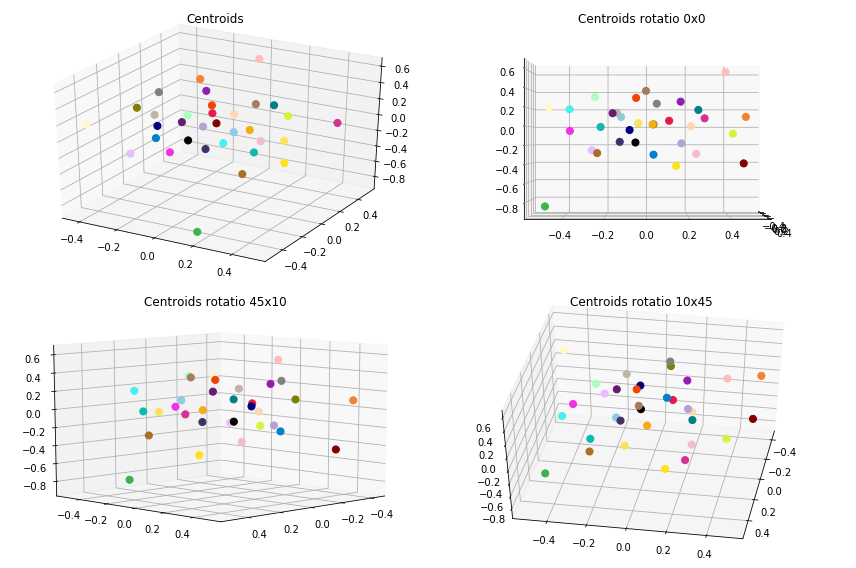

In [13]:
mds = MDS(
    n_components=3,
    n_init=5,
    max_iter=500,
    random_state=0,
    n_jobs=-1
)
X_cnt = mds.fit_transform(centroids)

plt.figure(figsize=(12, 8))
ax = plt.subplot(2, 2, 1, projection='3d')
plt.title("Centroids")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors, alpha=1, s=50)
ax = plt.subplot(2, 2, 2, projection='3d')
plt.title("Centroids rotatio 0x0")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors, alpha=1, s=50)
ax.view_init(0, 0)
ax = plt.subplot(2, 2, 3, projection='3d')
plt.title("Centroids rotatio 45x10")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors, alpha=1, s=50)
ax.view_init(10, 45)
ax = plt.subplot(2, 2, 4, projection='3d')
plt.title("Centroids rotatio 10x45")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors, alpha=1, s=50)
ax.view_init(45, 10)
plt.tight_layout()
plt.show()

### Clusterização dos dados de Teste

Por fim, realizada a clusterização dos dados de teste e a apresentação das 8 primeiras frases do conjunto de teste juntamente com outras duas frases do cluster ao qual foi identificado como o melhor.

In [14]:
Xtest = X_test.to_numpy()
for i, xt in enumerate(XT[:8]):
    clt = kclusterer.classify(xt)
    print("*", Xtest[i])
    for frase in utils.shuffle(df[df["cluster"] == clt].to_numpy())[:2]:
        print("  - ", frase[0])
    print("-" * 20)

* Quanto da área total no meu país é coberta pela recepção?
  -  Algo parece estar seriamente errado, já que nem posso fazer nem receber chamadas independentemente de onde estou.
  -  Existem áreas sem recepção das quais que eu deveria estar ciente?
--------------------
* acesso ao meu email foi negado
  -  estou com bloqueio no meu email
  -  Como eu faço para criar um email institucional
--------------------
* voce nao conseguiu me ajudar, quero falar com um humano
  -  Será que um humano pode me atender?
  -  Quero falar com um humano
--------------------
* voce nao sabe nada sobre vpn?
  -  Olá, eu gostaria de saber como manter meu número antigo do meu provedor de serviços anterior na minha nova conta com vocês, por favor
  -  Gostaria de falar com um representante de serviço ao cliente para saber sobre a adição de novos serviços ao meu plano.
--------------------
* Posso usar o meu telefone quando estou no exterior de férias e quais serão as tarifas?
  -  Como posso recarregar meu

### Métricas

Abaixo são apresentadas métricas para demonstrar o quanto a clusterização parece funcionar.

In [15]:
hom = homogeneity_score(y_test, [kclusterer.classify(xt) for xt in XT])
compl = completeness_score(y_test, [kclusterer.classify(xt) for xt in XT])
silh = silhouette_score(XT, labels=[kclusterer.classify(xt) for xt in XT], metric="cosine", random_state=0)

print("Homogeneidade: ", np.round(hom, 3))
print("Completude   : ", np.round(compl, 3))
print("Silhouette   : ", np.round(silh, 3))

Homogeneidade:  0.646
Completude   :  0.669
Silhouette   :  0.039


In [16]:
t_cluster = 40

clusterizacao = []
for k in range(2, t_cluster):
    kclusterer = KMeansClusterer(k, distance=nltk.cluster.util.cosine_distance, repeats=20, avoid_empty_clusters=True)
    assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
    assigned_clusters = np.array(assigned_clusters).ravel()
    centroids = kclusterer.means()
    
    hom = homogeneity_score(y_test, [kclusterer.classify(xt) for xt in XT])
    compl = completeness_score(y_test, [kclusterer.classify(xt) for xt in XT])
    silh = silhouette_score(XT, labels=[kclusterer.classify(xt) for xt in XT], metric="cosine", random_state=0)

    clusterizacao.append({
        "Qtd. Cluster": k,
        "Homogeneity": np.round(hom, 3),
        "Completeness": np.round(compl, 3),
        "Silhouette": np.round(silh, 3),
    })

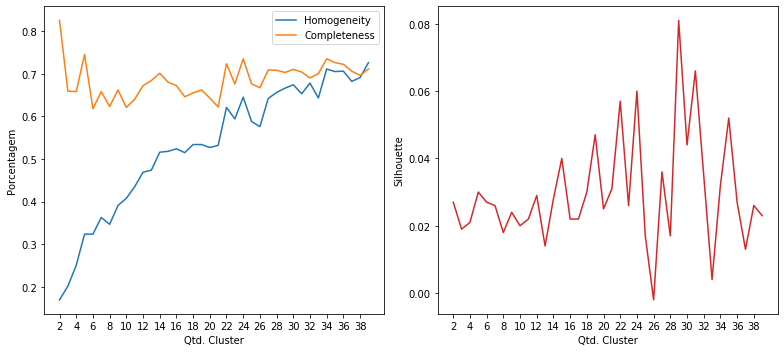

In [17]:
df_cluster = pd.DataFrame(clusterizacao, columns=["Qtd. Cluster", "Homogeneity", "Completeness", "Silhouette"])

plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.plot(df_cluster["Qtd. Cluster"], df_cluster["Homogeneity"], label="Homogeneity")
plt.plot(df_cluster["Qtd. Cluster"], df_cluster["Completeness"], label="Completeness")
plt.xticks(range(2, 40, 2))
plt.xlabel("Qtd. Cluster")
plt.ylabel("Porcentagem")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("")
plt.plot(df_cluster["Qtd. Cluster"], df_cluster["Silhouette"], c="C3")
plt.xticks(range(2, 40, 2))
plt.xlabel("Qtd. Cluster")
plt.ylabel("Silhouette")
plt.tight_layout()
plt.show()